# Stage 2 AI training: time window points

This stage focuses on selecting the **optimal time window's length**. Different architectures and rotational frames will be used for every time window option.

In [8]:
# Import packages:
import MLQDM.MLmodel as ML_MLmodel
import MLQDM.timewindows as ML_twdw
import tensorflow as tf

# Check available GPU:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load original data and general parameters
Load data from files (many segments) and store information in dataframes, one for each segment. The original data is in the **Laboratory rotational frame (RF1)**.

There are two possible sets of target labels, coming for the 'linear approximation' of 'physical model' approaches regarding the interpolated positions. You must choose one as {interp} for the training stage:
* **'lin_approx'** : linear approximation.
* **'phys_model'** : physical model based on acceleration profile.

In [2]:
# Choose Z-position interpolation method:
interp = 'phys_model' # 'phys_model' or 'lin_approx'

# Prepare files information:
data_path =  '../Data/' # Datafiles path
gen_pars_path = 'ML_parameters/'

# Load data, general hyperparameters and rotational frames:
data, hypers, RFs = ML_MLmodel.load_data_and_gen_pars(
    data_path,gen_pars_path,interp=interp,final_stage=False)

## Generate time windows

### Load original data

Each data segment is processed into time windows, which must have a fixed time length (or equivalently, fixed number of points) by default. However, as the original data is stored in the Time_Wdw object, it can be reshaped later.

The distribution of training and testing datasets is chosen here. The validation dataset is included within the training dataset.

Summary for time windows within training and testing datasets:

Number of points for every time window: 20
Time resolution: 0.1000 s

 --------------------  Training dataset  -------------------- 

time_0_to_59min: 35719 points, 59 min
time_600_to_717min: 70561 points, 117 min
time_420_to_595min: 105475 points, 175 min
Total points/time: 211755 / 5.88 hours

 --------------------  Testing dataset  -------------------- 

time_240_to_419min: 107138 points, 178 min
time_60_to_239min: 107601 points, 179 min
Total points/time: 214739 / 5.96 hours


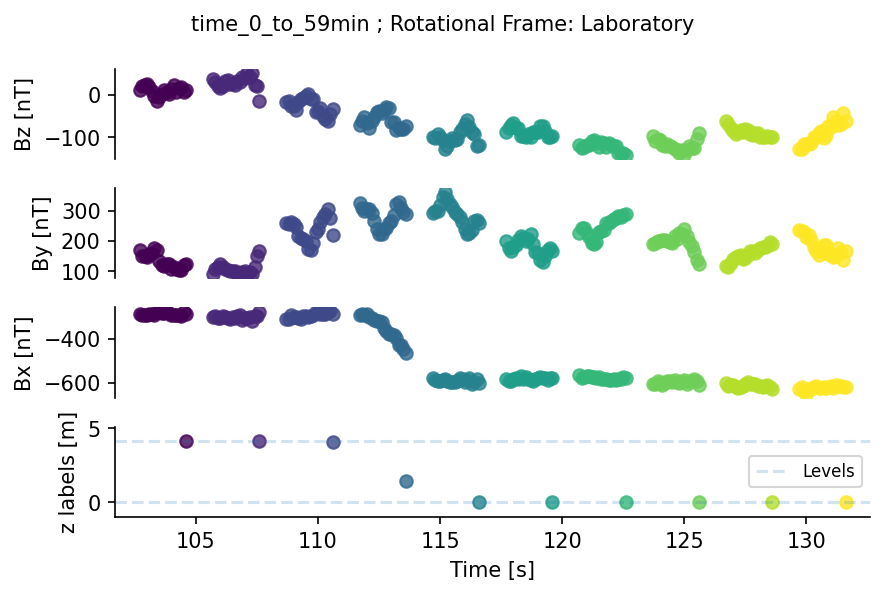

In [3]:
# Prepare time windows:
wdw_pp = 20
train_segm = [0,4,3] if interp == 'phys_model' else [2,3,4]
t_wdws_train, t_wdws_test = ML_twdw.prepare_time_windows(
    data,wdw_pp,train_segm=train_segm,
    plot_instances=True,instances=10,start_wdw=1025,stride_pp=30)

### Time Windows

From Stage 1 analysis, we've determined that only the full vector data, meaning all three $(Bx,By,Bz)$ magnetic components, is robust against rotations and has about 90% accuracy for position predictions using a 1-meter threshold.

In this Stage 2, we optimize the **[number of points for the Time Windows]**. Each input option will be combined with three different architectures:

1. A single Convolutional Neural Network (CNN) with 32 filters and kernel size 5 + Flattening layer + Two consecutive Dense Neural Network (DNN) with 512 neurons each.
2. Two consecutive CNN with 32 filters each and kernel sizes 8 and 4, respectively, + Flattening layer + Two consecutive DNN with 512 neurons each.
3. Three consecutive DNN with 1024, 512, 512 neurons, respectively.

In all cases, the last output layer is a DNN with a single neuron and linear activation, which predicts a single value for the elevator Z-position, units [m], representing the position at the end of the time window.

The general hyperparameters for all ML models are defined according to the 'ML_gen_pars_S1to6.json' file. In addition, the following hyperparameters are also common to all ML models:

* "Magnetic_Components": ['Bx','By','Bz'].
* "Dropout_Fraction": 0.
* "Activation_Function": 'relu'.
* "Optimizer": 'adam'.
* "Learning_Rate": 0.005.

In this stage, the standard rotational frames (RF1,RF2,RF3), described in the 'ML_RF_S1to6.json' file, are used to train and evaluate each ML model.

In [4]:
# Define additional hyperparameters:
extra_hypers = {
    "Magnetic_Components": ['Bx','By','Bz'],
    "Dropout_Fraction": 0,
    "Activation_Function": 'relu',
    "Optimizer": 'adam',
    "Learning_Rate": 0.005
}

# Define the architecture options:
arch1 = {
    "Convolutional_Network": True,
    "Conv_Layers": [[32,5]],
    "Pool_Layers": [None],
    "Flatten_Average": True,
    "Dens_Layers": [512,512],
    "Model_Name": "S2_C5_"
}
arch2 = {
    "Convolutional_Network": True,
    "Conv_Layers": [[32,8],[32,4]],
    "Pool_Layers": [None,None],
    "Flatten_Average": True,
    "Dens_Layers": [512,512],
    "Model_Name": "S2_C8_C4_"
}
arch3 = {
    "Convolutional_Network": False,
    "Dens_Layers": [1024,512,512],
    "Model_Name": "S2_D1024D512D512"
}

# Combine all hyperparameters information and architecture options:
arch_opts = [dict(list(hypers.items())+list(extra_hypers.items())+list(arch.items()))\
             for arch in [arch1,arch2,arch3]]

# Options for seeds:
seed_opts = [0,1,2]

# Prepare rotational frame options:
RF_opts = list(RFs.values())

In [5]:
# Options for number of points in time windows:
import numpy as np
pp_opts = np.concatenate([
    np.arange(1,10,1),np.arange(10,20,2),np.arange(20,60,4),np.arange(60,124+1,8)
    ],axis=0)

In [7]:
# Prepare file path to export results:
results_path = f'../Results/'
# Prepare file path to check on already trained models and avoid repetitions:
check_rep_model = f'../Results/Stage2_{interp}_all_Train_s1s4s5_Test_s2s3.csv'

# Train all models:
df_results = ML_MLmodel.train_stage2(
    pp_opts,arch_opts,RF_opts,t_wdws_train,t_wdws_test,
    interpolation=interp,seed_opts=seed_opts,
    results_path=results_path,check_rep_model=check_rep_model,
    quick_timing_test=False
)